This example will walk through the following:

* **Getting and processing the data.**
* **Defining a model and parameters.**
* **Finding the best parameters,** and some details on why we're using the chosen search algorithm.
* **Scoring** and deploying.

All of these tasks will be performed on the New York City Taxi Cab dataset.

## Setup cluster

In [ ]:
import coiled
import dask.distributed

In [ ]:
cluster = coiled.Cluster(
    n_workers=20, 
    configuration="coiled/default", 
)
client = dask.distributed.Client(cluster)

client

## Get and pre-process data

This example will mirror the Kaggle "[NYC Taxi Trip Duration][1]" example with different data.

These data have records on 84 million taxi rides.

[1]:https://www.kaggle.com/c/nyc-taxi-trip-duration/

In [2]:
import dask.dataframe as dd

features = ["passenger_count", "trip_distance", "fare_amount"]
categorical_features = ["RatecodeID", "payment_type"]
output = ["tpep_pickup_datetime", "tpep_dropoff_datetime"]

df = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2019-*.csv", 
    parse_dates=output,
    usecols=features + categorical_features + output,
    dtype={
        "passenger_count": "UInt8",
        "RatecodeID": "category",
        "payment_type": "category",
    },
    blocksize="16 MiB",
)

# one hot encode the categorical columns;
# if df["foo"].unique() == [1, 3, 4], add columns foo_1, foo_3, foo_4
df = dd.get_dummies(df, columns=categorical_features)

# persist so only download once
df = df.persist()

data = df[[c for c in df.columns if c not in output]]
data = data.fillna(0)

In [3]:
durations = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60  # minutes

In [4]:
from dask_ml.model_selection import train_test_split
import dask

features = data.to_dask_array(lengths=True).astype("float32")
output = durations.to_dask_array(lengths=True).astype("float32")
X_train, X_test, y_train, y_test = train_test_split(features, output, shuffle=True)

# persist the data so it's not re-computed
X_train, X_test, y_train, y_test = dask.persist(X_train, X_test, y_train, y_test)

## Define model and hyperparameters

Let's use a simple neural network from [PyTorch] usin Skorch, a simple wrapper that provides a Scikit-Learn API for PyTorch.

This network is only small for demonstration. If desired, we could use much larger networks on GPUs.

[PyTorch]:https://pytorch.org/
[skorch]:https://skorch.readthedocs.io/en/stable/

If desired, this model could use GPUs.

In [5]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

class HiddenLayerNet(nn.Module):
    def __init__(self, n_features=10, n_outputs=1, n_hidden=100, activation="relu"):
        super().__init__()
        self.fc1 = nn.Linear(n_features, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_outputs)
        self.activation = getattr(F, activation)

    def forward(self, x, **kwargs):
        return self.fc2(self.activation(self.fc1(x)))

In [6]:
from torch_model import HiddenLayerNet

In [7]:
X_train.shape

(900, 14)

In [8]:
from skorch import NeuralNetRegressor

niceties = {
    "callbacks": False,
    "warm_start": True,
    "train_split": None,
    "max_epochs": 1,
}

model = NeuralNetRegressor(
    module=HiddenLayerNet,
    module__n_features=X_train.shape[1],
    optimizer=optim.SGD,
    criterion=nn.MSELoss,
    lr=0.0001,
    **niceties,
)

In [9]:
from scipy.stats import loguniform, uniform

params = {
    "module__activation": ["relu", "elu", "softsign", "leaky_relu", "rrelu"],
    "batch_size": [32, 64, 128, 256],
    "optimizer__lr": loguniform(1e-4, 1e-3),
    "optimizer__weight_decay": loguniform(1e-6, 1e-3),
    "optimizer__momentum": uniform(0, 1),
    "optimizer__nesterov": [True],
}

All of these parameters control model architecture, execpt for two basic optimizatino parameters, `batch_size` and `learning_rate_init`. They control finding the best model of a particular architecture.

## Find the best hyperparameters

Our search is "computationally-constrained" because (hypothetically) it requires GPUs and has a pretty complicated search space (in reality it has neither of those features). And obviously it's "memory-constrained" because the dataset doesn't fit in memory.

[Dask-ML's documentation on hyperparameter searches][2] indicates that we should use `HyperbandSearchCV`.

[2]:https://ml.dask.org/hyper-parameter-search.html

In [10]:
from dask_ml.model_selection import HyperbandSearchCV
search = HyperbandSearchCV(model, params, random_state=42, verbose=True, max_iter=9)

By default, `HyperbandSearchCV` will call `partial_fit` on each chunk of the Dask Array. `HyperbandSearchCV`'s rule of thumb specifies how to train for longer or sample more parameters.

In [12]:
y_train2 = y_train.reshape(-1, 1).persist()
_ = search.fit(X_train, y_train2)

[CV, bracket=2] creating 9 models
[CV, bracket=1] creating 5 models
[CV, bracket=0] creating 3 models
[CV, bracket=0] For training there are between 360 and 360 examples in each chunk
[CV, bracket=1] For training there are between 360 and 360 examples in each chunk
[CV, bracket=0] validation score of -0.3191 received after 1 partial_fit calls
[CV, bracket=2] For training there are between 360 and 360 examples in each chunk
[CV, bracket=1] validation score of 0.0170 received after 1 partial_fit calls
[CV, bracket=1] validation score of 0.0322 received after 3 partial_fit calls
[CV, bracket=2] validation score of 0.2228 received after 1 partial_fit calls
[CV, bracket=2] validation score of -0.7214 received after 3 partial_fit calls
[CV, bracket=1] validation score of 0.0183 received after 9 partial_fit calls
[CV, bracket=0] validation score of -0.2677 received after 9 partial_fit calls
[CV, bracket=2] validation score of -0.5336 received after 9 partial_fit calls


HyperbandSearchCV(estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class 'torch_model.HiddenLayerNet'>,
  module__n_features=14,
),
                  max_iter=9,
                  parameters={'batch_size': [32, 64, 128, 256],
                              'module__activation': ['relu', 'elu', 'softsign',
                                                     'leaky_relu', 'rrelu'],
                              'optimizer__lr': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1318ea6d0>,
                              'optimizer__momentum': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1318eae50>,
                              'optimizer__nesterov': [True],
                              'optimizer__weight_decay': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1318eaca0>},
                  random_state=42, verbose=True)

## Score

`HyperbandSearchCV` and the like mirror the Scikit-Learn model selection interface, so all attributes of Scikit-Learn's [RandomizedSearchCV][rscv] are available:

[rscv]:https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [17]:
search.best_score_

0.018286365127180515

In [18]:
search.best_params_

{'batch_size': 32,
 'module__activation': 'rrelu',
 'optimizer__lr': 0.0002668107973843001,
 'optimizer__momentum': 0.5920831762255758,
 'optimizer__nesterov': True,
 'optimizer__weight_decay': 3.6363529586270234e-05}

In [19]:
search.best_estimator_

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=HiddenLayerNet(
    (fc1): Linear(in_features=14, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=1, bias=True)
  ),
)

This means we can deploy the best model and score on the entire dataset:

In [20]:
from dask_ml.wrappers import ParallelPostFit
deployed_model = ParallelPostFit(search.best_estimator_)
deployed_model.score(X_test, y_test)

0.33630241003610284

## Visualization

What does the error distribution look like on this larger dataset?

In [103]:
y_pred = deployed_model.predict(X_test)
y_pred = y_pred.flatten()

In [108]:
y_pred

dask.array<_predict, shape=(100,), dtype=int64, chunksize=(50,), chunktype=numpy.ndarray>

In [109]:
import numpy as np
import pandas as pd
import dask.array as da

err = np.abs(y_pred - y_test)
max_min_err = 20
vals, edges = da.histogram(err, range=(0, max_min_err), bins=max_min_err)
vals, edges = dask.compute(vals, edges)

In [110]:
y_test.shape

(100,)

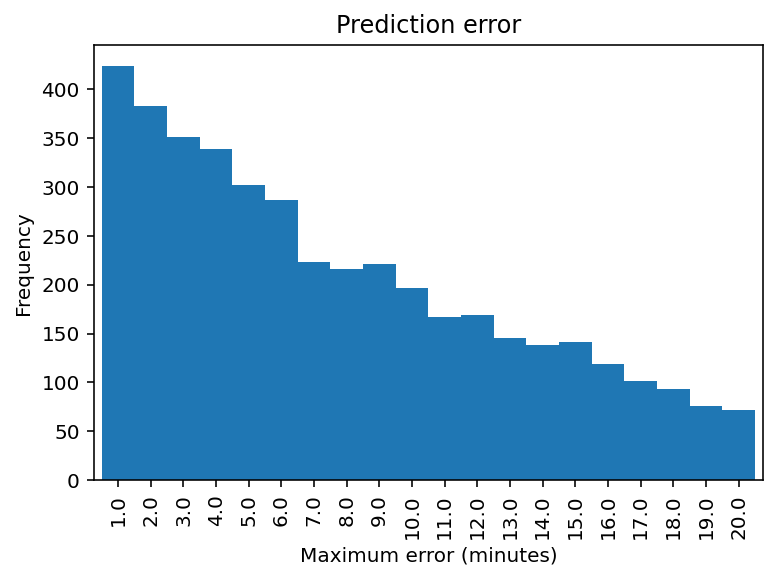

In [111]:
df = pd.DataFrame({"vals": vals, "edges": edges[1:]})
ax = df.plot.bar(x="edges", y="vals", width=1)
ax.set_ylabel("Frequency")
ax.set_xlabel("Maximum error (minutes)")
ax.set_title("Prediction error")
ax.legend_.remove()

## Why not simply sampling instead?

Sampling solves the memory issues:

In [ ]:
X_train_small =  X_train.sample(frac=0.01, random_state=123).compute()
y_train_small = y_train.sample(frac=0.01, random_state=123).compute()

X_train_small  # NumPy ndarray; must fit in memory

But `HyperbandSearchCV` is meant for computationally-constrained problems, regardless of their memory usage (which [Dask-ML's documentation on hyperparameter searches][2] also indicate). `HyperbandSearchCV` would still be relevant:

[2]:https://ml.dask.org/hyper-parameter-search.html

In [ ]:
search = HyperbandSearchCV(model, params, max_iter=81, random_state=0)
search.fit(X_train_small, y_train_small, classes=[0, 1]);

`HyperbandSearchCV` would not be relevant when the search problem is not computationally-constrained, which happens with a smaller search space or a simpler model that doesn't require GPUs.

If we had a simpler model and a massive dataset, `IncrementalSearchCV` is recommended. It mirrors Scikit-Learn's `RandomizedSearchCV` but works on Dask Arrays/Dataframes, both of which can be larger than memory.